## 1. Problem Statement: Does one's lifestyle plays a very important role such that cardiovascular disease may happen?

In [1]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import math

sb.set() # set the default Seaborn style for graphics

In [2]:
# extras libraries
import seaborn as sns
%matplotlib inline

sns.set_style('white')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    zero_one_loss, 
    accuracy_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)

import warnings
warnings.filterwarnings('ignore')

## 2. Data clean-up/ preparation:

#### We will be cleaning up the data by relabelling indexes for categorical datasets and introducing new variables - Blood Pressure Level (BP) and Body Mass Index (BMI)

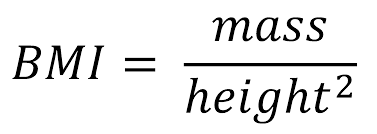

In [27]:
#data1 is for EDA purposes
#remove 'id' since unneccessary.
data1 = pd.read_csv('cardio_train.csv', delimiter=";").drop('id', axis=1)

# changing age --> days to year
data1['age'] =  (data1['age']/365).astype("int64")

# changing weight --> float to int
data1['weight'] =  data1['weight'].astype("int64")

# combine height and weight to bmi
data1['BMI'] = (data1['weight']/(data1['height']/100)**2).round(2)

data1.head(5) #show first 5

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62,110,80,1,1,0,0,1,0,21.97
1,55,1,156,85,140,90,3,1,0,0,1,1,34.93
2,51,1,165,64,130,70,3,1,0,0,0,1,23.51
3,48,2,169,82,150,100,1,1,0,0,1,1,28.71
4,47,1,156,56,100,60,1,1,0,0,0,0,23.01


In [28]:
#check for any duplicates

data1.duplicated().sum()

3213

In [29]:
#drop duplicates; in this case got 3213 duplicates after removing 'id'

data1.duplicated().sum()

data1.drop_duplicates(inplace = True)

data1

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62,110,80,1,1,0,0,1,0,21.97
1,55,1,156,85,140,90,3,1,0,0,1,1,34.93
2,51,1,165,64,130,70,3,1,0,0,0,1,23.51
3,48,2,169,82,150,100,1,1,0,0,1,1,28.71
4,47,1,156,56,100,60,1,1,0,0,0,0,23.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,57,1,165,80,150,80,1,1,0,0,1,1,29.38
69996,61,1,158,126,140,90,2,2,0,0,1,1,50.47
69997,52,2,183,105,180,90,3,1,0,1,0,1,31.35
69998,61,1,163,72,135,80,1,2,0,0,0,1,27.10


In [30]:
#check for any missing values
#no missing values

data1.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
BMI            0
dtype: int64

In [31]:
# check what's the remaining columns and rows
data1.shape

(66787, 13)

In [32]:
#check ap_hi statistics; 
#from here you can see the max val is 16020, min value -150; could be errors on the data

ap_hi = pd.DataFrame(data1['ap_hi'])
ap_hi.describe()

,ap_hi
count,66787.000000
mean,129.232126
std,157.655220
min,-150.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,16020.000000


In [33]:
#check ap_lo statistics; 
#from here you can see the max val is 11000, min value -70

ap_lo = pd.DataFrame(data1['ap_lo'])
ap_lo.describe()

,ap_lo
count,66787.000000
mean,97.447677
std,192.913579
min,-70.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,11000.000000


### Filtering of outliers from ap_hi and ap_lo

#### By limiting the numbers of ap_hi and ap_lo for the data to be realistic and more accurate; from research we found that there cant be any negative systolic and diastolic pressure, we set threshold to be 0 < x < 300 where x = ap.hi and ap.lo. Even though these outliers are valid datasets, these outliers increase skewness. Also, extreme outliers increase the variability in our data, which decreases statistical power thus the accuracy.

https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

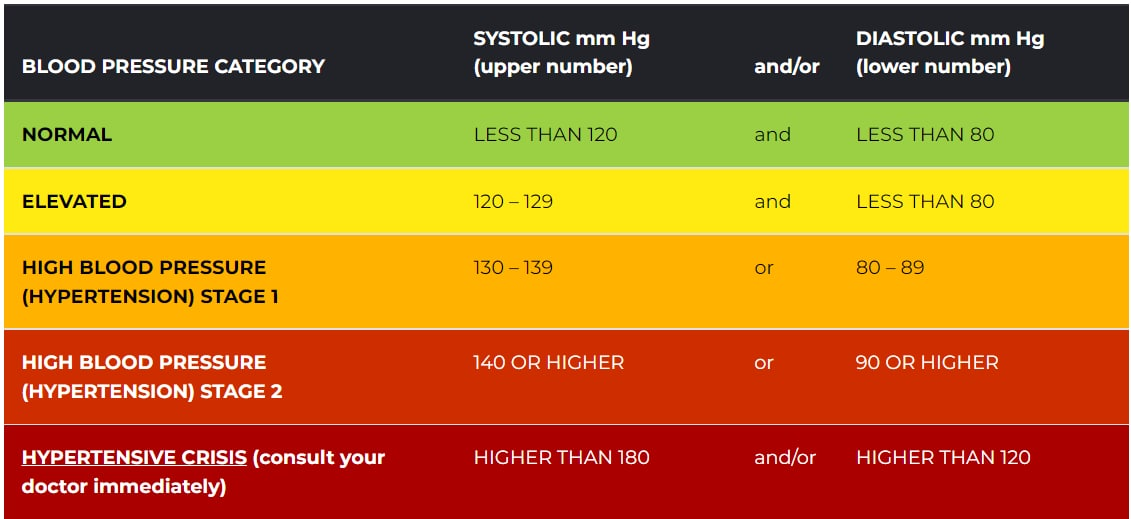


In [34]:
# percentage of data w/ systolic pressure =<0 and >300
# setting realistic limits for systolic pressure to be 0 < ap_hi < 300

bad_aphi = (data1.ap_hi <= 0) | (data1.ap_hi > 300)
data1[bad_aphi].ap_hi.count() / data1.ap_hi.count()

# note that only 0.07% of data is affected, so we can safely remove those 'outliers' data.

0.0007037297677691766

In [35]:
# percentage of data w/ diastolic pressure =<0 and >300
# we are setting realistic limits for diastolic pressure to be 0 < ap_lo < 300

bad_aphi = (data1.ap_lo <= 0) | (data1.ap_lo > 300)
data1[bad_aphi].ap_lo.count() / data1.ap_lo.count()

# note that only 1.4% of data is affected, hence can safely remove those 'outliers' data.

0.014598649437764835

In [36]:
# dropping Systolic blood pressure that are more than 300 & less than or equal to 0
for x in data1.index:
  if data1.loc[x, "ap_hi"] > 300:
    data1.drop(x, inplace = True)
    
for x in data1.index:
  if data1.loc[x, "ap_hi"] <= 0:
    data1.drop(x, inplace = True)


# dropping Diastolic blood pressure that are more than 300 & less than or equal to 0 
for x in data1.index:
  if data1.loc[x, "ap_lo"] > 300:
    data1.drop(x, inplace = True)
    
for x in data1.index:
  if data1.loc[x, "ap_lo"] <= 0:
    data1.drop(x, inplace = True)

In [37]:
# remaining columns and rows after dropping the outliers of ap_hi and ap_lo 
data1.shape

(65772, 13)

#### The code below is introducing new label for BP level as previously mentioned. We are also classifying it based on the category shown on the picture above.

In [38]:
def aphi_func(x):
    
    if x >= 0 and x<= 90:
         return 5 #hypotension
    if x >90 and x<= 129:
         return 1 #normal/ elevated
        
    if x >129 and x<= 139:
         return 2 #hbp stage 1
    if x >139 and x<= 180:
         return 3 #hbp stage 2
    else:
         return 4 #hbp hypertensive 
        
def aplo_func(x):
    
    if x >= 0 and x<= 60:
        return 5 #hypotension
    if x >60 and x <= 80:
         return 1 #normal/ elevated
        
    if x > 80  and x <= 89:
         return 2 #hbp stage 1
        
    if x >90 and x<= 120:
         return 3 #hbp stage 2
    
    else:
         return 4 #hbp hypertensive
        
#this implements the function onto the column of choice.
data1['aphi_class'] = data1['ap_hi'].apply(lambda x: aphi_func(x))
data1['aplo_class'] = data1['ap_lo'].apply(lambda x: aplo_func(x))

data1['BP']=data1[['aphi_class','aplo_class']].max(axis=1)
data1.head(5) #show first 5

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,aphi_class,aplo_class,BP
0,50,2,168,62,110,80,1,1,0,0,1,0,21.97,1,1,1
1,55,1,156,85,140,90,3,1,0,0,1,1,34.93,3,4,4
2,51,1,165,64,130,70,3,1,0,0,0,1,23.51,2,1,2
3,48,2,169,82,150,100,1,1,0,0,1,1,28.71,3,3,3
4,47,1,156,56,100,60,1,1,0,0,0,0,23.01,1,5,5


In [39]:
# summary: for a better representation of categorical data
data1['gender'].replace({1: 'woman', 2: 'man'}, inplace = True)
data1['cholesterol'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
data1['gluc'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
data1['smoke'].replace({0: 'No', 1: 'Yes'}, inplace = True)
data1['alco'].replace({0: 'No', 1: 'Yes'}, inplace = True)
data1['active'].replace({0: 'No', 1: 'Yes'}, inplace = True)
data1['cardio'].replace({0: 'No', 1: 'Yes'}, inplace = True)
data1['BP'].replace({1: 'Normal/ Elevated', 2: 'high blood pressure stage 1', 3: 'high blood pressure stage 2', 4: 'Hypertension', 5:'Hypotension'}, inplace = True)
data1['aphi_class'].replace({1: 'Normal/ Elevated', 2: 'high blood pressure stage 1', 3: 'high blood pressure stage 2', 4: 'Hypertension', 5:'Hypotension'}, inplace = True)
data1['aplo_class'].replace({1: 'Normal/ Elevated', 2: 'high blood pressure stage 1', 3: 'high blood pressure stage 2', 4: 'Hypertension', 5:'Hypotension'}, inplace = True)

data1.head(10) #show the first 10 datas

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,aphi_class,aplo_class,BP
0,50,man,168,62,110,80,normal,normal,No,No,Yes,No,21.97,Normal/ Elevated,Normal/ Elevated,Normal/ Elevated
1,55,woman,156,85,140,90,well above normal,normal,No,No,Yes,Yes,34.93,high blood pressure stage 2,Hypertension,Hypertension
2,51,woman,165,64,130,70,well above normal,normal,No,No,No,Yes,23.51,high blood pressure stage 1,Normal/ Elevated,high blood pressure stage 1
3,48,man,169,82,150,100,normal,normal,No,No,Yes,Yes,28.71,high blood pressure stage 2,high blood pressure stage 2,high blood pressure stage 2
4,47,woman,156,56,100,60,normal,normal,No,No,No,No,23.01,Normal/ Elevated,Hypotension,Hypotension
5,60,woman,151,67,120,80,above normal,above normal,No,No,No,No,29.38,Normal/ Elevated,Normal/ Elevated,Normal/ Elevated
6,60,woman,157,93,130,80,well above normal,normal,No,No,Yes,No,37.73,high blood pressure stage 1,Normal/ Elevated,high blood pressure stage 1
7,61,man,178,95,130,90,well above normal,well above normal,No,No,Yes,Yes,29.98,high blood pressure stage 1,Hypertension,Hypertension
8,48,woman,158,71,110,70,normal,normal,No,No,Yes,No,28.44,Normal/ Elevated,Normal/ Elevated,Normal/ Elevated
9,54,woman,164,68,110,60,normal,normal,No,No,No,No,25.28,Normal/ Elevated,Hypotension,Hypotension


In [40]:
# Separating numeric and categorical columns
numeric_cols = data1.select_dtypes(include = np.number).columns.tolist()
print("Numerical Columns:", numeric_cols)

categorical_cols = data1.select_dtypes(include = 'object').columns.tolist()
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']
Categorical Columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'aphi_class', 'aplo_class', 'BP']


## 3. Exploratory data analysis part 1 (numerical datas)


0.6491210510376353

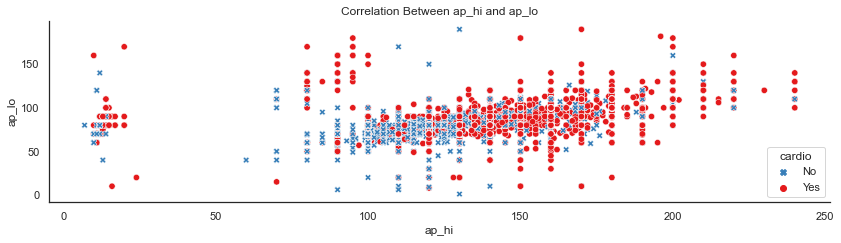

In [42]:
# Visualizing ap_hi and ap_lo
fig = plt.figure(figsize = (14, 8), constrained_layout = True)
gs = fig.add_gridspec(2, 4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
palette = {'No': '#377EB8', 'Yes': '#E41A1C'}

# Scatter plot to observe correlation between ap_hi and ap_lo
ax3 = fig.add_subplot(gs[1, :])
ax3 = sns.scatterplot(data = data1, x = 'ap_hi', y = 'ap_lo', hue = 'cardio', palette = palette, 
                style = 'cardio', markers = {'No': 'X', 'Yes': 'o'}, s = 40)
ax3.set_title('Correlation Between ap_hi and ap_lo')

sns.despine();

data1['ap_hi'].corr(data1['ap_lo'])
# the correlation coefficient between ap_hi and ap_lo is about 0.65

In [43]:
mean_aphi = data1['ap_hi'].mean()
mean_aplo = data1['ap_lo'].mean()

cardio_count = data1[(data1['ap_hi'] > mean_aphi) & (data1['ap_lo'] > mean_aplo)].cardio.value_counts()
cardio_count / cardio_count.sum()



Yes    0.797929
No     0.202071
Name: cardio, dtype: float64

#### Based on this data, if the person's ap_hi and ap_lo is above the mean, the probability of having cvd is ~0.8

In [45]:
# Extract only the numeric data variables
numeric_data = pd.DataFrame(data1[["age", "height", "weight", "ap_hi", "ap_lo", "BMI"]])

# Summary Statistics for all Variables
numeric_data.describe().round(2)

,age,height,weight,ap_hi,ap_lo,BMI
count,65772.00,65772.00,65772.00,65772.00,65772.00,65772.00
mean,52.85,164.34,74.43,126.62,81.43,27.65
std,6.81,8.33,14.52,18.02,10.00,6.18
min,29.00,55.00,11.00,7.00,1.00,3.47
25%,48.00,159.00,65.00,120.00,80.00,23.88
50%,53.00,165.00,72.00,120.00,80.00,26.56
75%,58.00,170.00,82.00,140.00,90.00,30.44
max,64.00,250.00,200.00,240.00,190.00,298.67


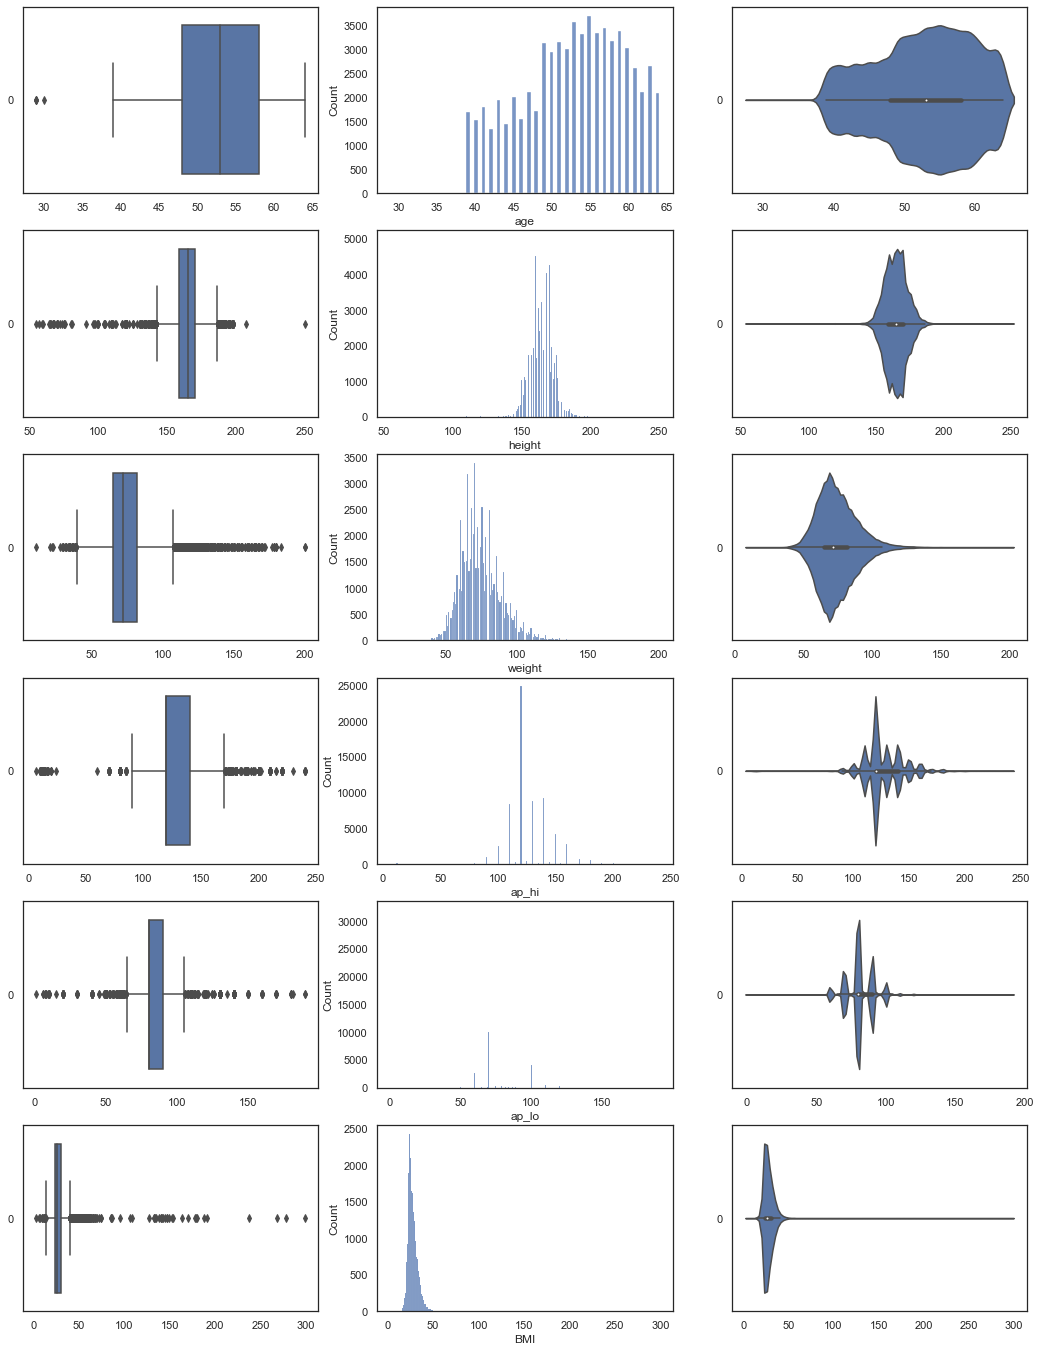

In [46]:
# Draw the distributions of numerical variables
f, axes = plt.subplots(6, 3, figsize=(18, 24))

count = 0
for var in numeric_data:
    sb.boxplot(data = numeric_data[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    sb.violinplot(data = numeric_data[var], orient = "h", ax = axes[count,2])
    count += 1

             age    height    weight     ap_hi     ap_lo       BMI
age     1.000000 -0.082762  0.054386  0.199264  0.151857  0.086392
height -0.082762  1.000000  0.292400  0.018366  0.036284 -0.294212
weight  0.054386  0.292400  1.000000  0.250659  0.245252  0.756855
ap_hi   0.199264  0.018366  0.250659  1.000000  0.649121  0.211951
ap_lo   0.151857  0.036284  0.245252  0.649121  1.000000  0.199191
BMI     0.086392 -0.294212  0.756855  0.211951  0.199191  1.000000


<AxesSubplot:>

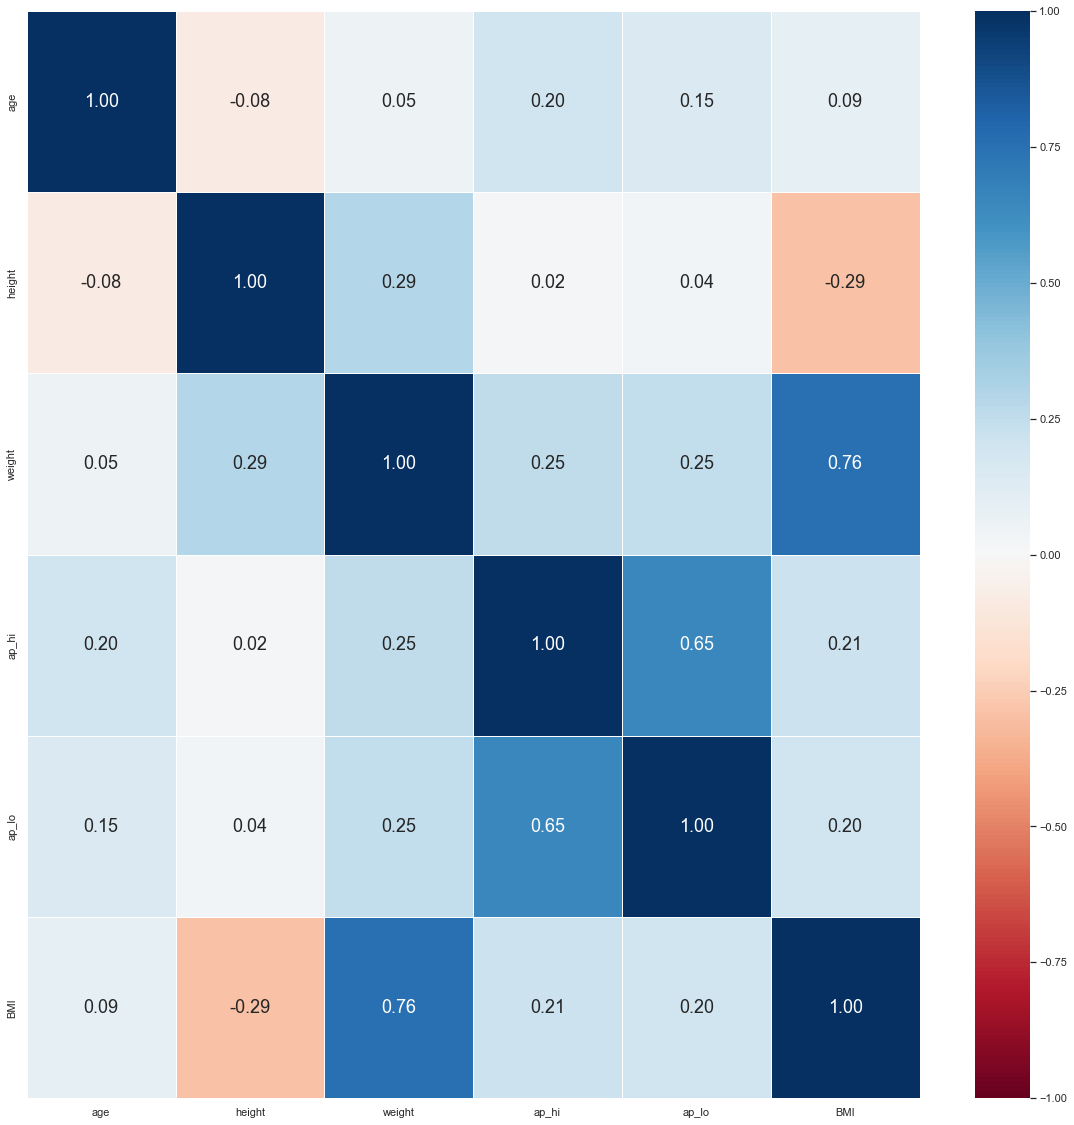

In [47]:
# Correlation Matrix for numerical vals
print(numeric_data.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sb.heatmap(numeric_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

#### From heatmap above, the linear correlation seems to be the case for ap_hi and ap_lo as did previously.

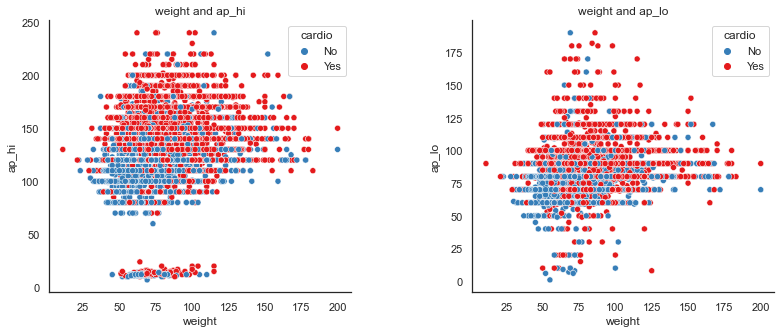

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
plt.subplots_adjust(wspace = 0.4)

ax1 = sns.scatterplot(data = data1, x = 'weight', y = 'ap_hi', hue = 'cardio', palette = palette, ax = axes.flat[0])
ax1.set_title('weight and ap_hi')

ax2 = sns.scatterplot(data = data1, x = 'weight', y = 'ap_lo', hue = 'cardio', palette = palette, ax = axes.flat[1])
ax2.set_title('weight and ap_lo')

sns.despine();

#### From the scatterplot above, we can see that major of people that has cvd weigh more and have higher ap_hi and ap_lo from this dataset.

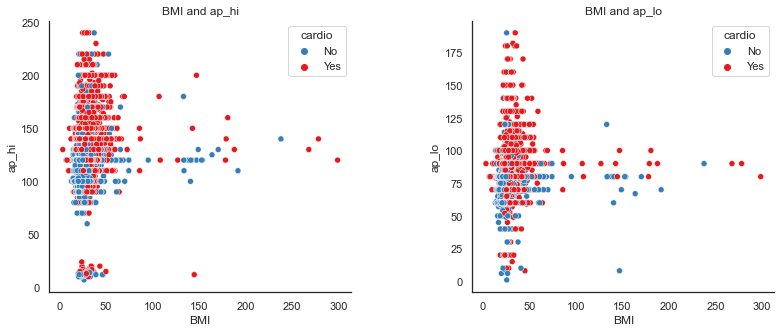

In [50]:
# comparing bmi and ap_hi & bmi and ap_lo

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
plt.subplots_adjust(wspace = 0.4)

ax1 = sns.scatterplot(data = data1, x = 'BMI', y = 'ap_hi', hue = 'cardio', palette = palette, ax = axes.flat[0])
ax1.set_title('BMI and ap_hi')

ax2 = sns.scatterplot(data = data1, x = 'BMI', y = 'ap_lo', hue = 'cardio', palette = palette, ax = axes.flat[1])
ax2.set_title('BMI and ap_lo')

sns.despine();

In [51]:
# analysis values for scatterplot against weight & ap_hi and ap_lo

mean_weight = data1['weight'].mean()
weight_and_aphi = data1[(data1['weight'] > mean_weight) & (data1['ap_hi'] > mean_aphi)].cardio.value_counts()
weight_and_aplo = data1[(data1['weight'] > mean_weight) & (data1['ap_lo'] > mean_aplo)].cardio.value_counts()
weight_aphi_aplo = data1[(data1['weight'] > mean_weight) & (data1['ap_hi'] > mean_aphi) & (data1['ap_lo'] > mean_aplo)].cardio.value_counts()

print('For people who weigh more and have higher ap_hi:')
print(weight_and_aphi / weight_and_aphi.sum())
print('---------------------------------------\n')

print('For people who weigh more and have higher ap_lo:')
print(weight_and_aplo / weight_and_aplo.sum())
print('---------------------------------------\n')

print('For people who weigh more as well as have higher ap_hi and ap_lo:')
print(weight_aphi_aplo / weight_aphi_aplo.sum())

For people who weigh more and have higher ap_hi:
Yes    0.766337
No     0.233663
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more and have higher ap_lo:
Yes    0.779885
No     0.220115
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more as well as have higher ap_hi and ap_lo:
Yes    0.803226
No     0.196774
Name: cardio, dtype: float64


In [52]:
# analysis values for scatterplot against BMI & ap_hi and ap_lo

mean_bmi = data1['BMI'].mean()
bmi_and_aphi = data1[(data1['BMI'] > mean_bmi) & (data1['ap_hi'] > mean_aphi)].cardio.value_counts()
bmi_and_aplo = data1[(data1['BMI'] > mean_bmi) & (data1['ap_lo'] > mean_aplo)].cardio.value_counts()
bmi_aphi_aplo = data1[(data1['BMI'] > mean_bmi) & (data1['ap_hi'] > mean_aphi) & (data1['ap_lo'] > mean_aplo)].cardio.value_counts()

print('For people who has higher BMI and have higher ap_hi:')
print(bmi_and_aphi / bmi_and_aphi.sum())
print('---------------------------------------\n')

print('For people who has higher BMI and have higher ap_lo:')
print(bmi_and_aplo / bmi_and_aplo.sum())
print('---------------------------------------\n')

print('For people who has higher BMI as well as have higher ap_hi and ap_lo:')
print(bmi_aphi_aplo / bmi_aphi_aplo.sum())

For people who has higher BMI and have higher ap_hi:
Yes    0.765659
No     0.234341
Name: cardio, dtype: float64
---------------------------------------

For people who has higher BMI and have higher ap_lo:
Yes    0.778616
No     0.221384
Name: cardio, dtype: float64
---------------------------------------

For people who has higher BMI as well as have higher ap_hi and ap_lo:
Yes    0.799961
No     0.200039
Name: cardio, dtype: float64


#### Comparing BMI and Weight with ap_hi and ap_lo, they have ~about the same probability. This is true as BMI is proportional to weight.

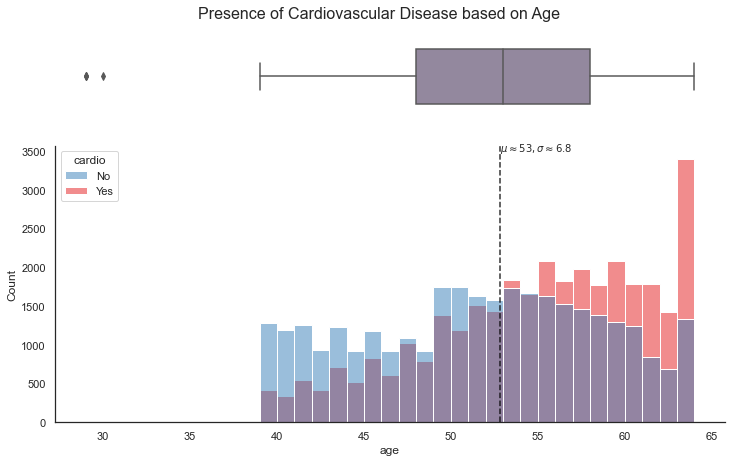

In [53]:
# Visualizing CVD Based on Age
fig, axes = plt.subplots(2, 1, figsize = (12, 7), sharex = True, gridspec_kw = {'height_ratios': [1, 4]})
fig.suptitle('Presence of Cardiovascular Disease based on Age', fontsize = 16, y = 0.95)

# Boxplot 
sns.boxplot(data = data1, x = 'age', ax = axes.flat[0], color = '#9384A2')
axes[0].set(xlabel = None)
sns.despine(bottom = True, left = True, ax = axes.flat[0])

# Histogram Plot Based on Age
sns.histplot(data = data1, x = 'age', hue = 'cardio', binwidth = 1, palette = palette, stat = 'count', alpha = 0.5, ax = axes.flat[1])
plt.axvline(x = data1.age.mean(), color = 'black', linestyle = '--', alpha = 0.8)
plt.text(x = data1['age'].mean(), y = 3500, s = r'$\mu \approx 53, \sigma \approx 6.8$')
sns.despine(ax = axes.flat[1])

#### Generally from this graph, we can see that people of older age has cvd.

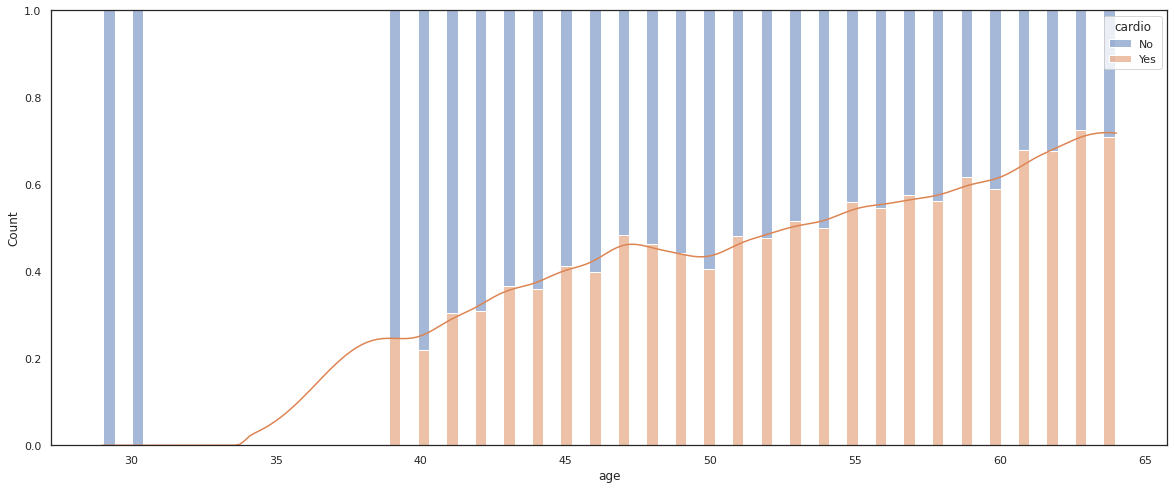

In [154]:
fig19, ax19 = plt.subplots(figsize=(20, 8))

sns.histplot(data=data1, x="age", hue="cardio", shrink=0.8, multiple="fill", kde=True, ax=ax19)
plt.show()

#### From the hist plot, there is clearly a +ve linear correlation evident of age wrt cardio. As such, we can say that as age increases, there is a strong likelyhood that a person may get cardio.

In [56]:
#further analysis with numbers: finding the probability of getting cvd for age is higher than mean.

mean = data1['age'].mean()
mean_age = round(mean)
print('Average age:', mean_age)

cardio_count = data1[(data1['age'] > mean_age) | (data1['age'] == mean_age)].cardio.value_counts()

print('\nIf your age is', mean_age, 'and above,')
print(cardio_count / cardio_count.sum())

Average age: 53

If your age is 53 and above,
Yes    0.593963
No     0.406037
Name: cardio, dtype: float64


In [57]:
#declaring datas for the next line of codes
big_height = data1.height > data1.height.mean()
small_height = data1.height < data1.height.mean()
big_weight = data1.weight > data1.weight.mean()
small_weight = data1.weight < data1.weight.mean()

sh_bw = data1[small_height & big_weight].groupby('cardio').cardio.count() # Quadrant 1 -> Big Height, Big Weight
bh_bw = data1[big_height & big_weight].groupby('cardio').cardio.count() # Quadrant 2 -> Small Height, Big Weight
bh_sw = data1[big_height & small_weight].groupby('cardio').cardio.count() # Quadrant 3 -> Small Height, Small Weight
sh_sw = data1[small_height & small_weight].groupby('cardio').cardio.count() # Quadrant 4 -> Big Height, Small Weight

names = [sh_bw, bh_bw, bh_sw, sh_sw]
totals = [name.sum() for name in names]

percent_df = pd.DataFrame([(name/ total).values for name, total in zip(names, totals)], columns = ['No', 'Yes'])

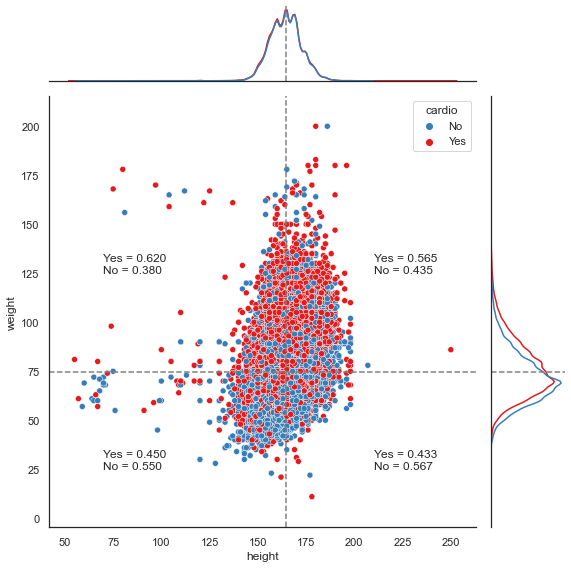

In [58]:
# The horizontal and vertical lines represent the mean values of the corresponding variables.
g = sns.JointGrid(data = data1, x = 'height', y = 'weight', hue = 'cardio', palette = palette, height = 8)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.kdeplot)
g.refline(x = data1.height.mean(), y = data1.weight.mean())

percent_df = pd.DataFrame([(name/ total).values for name, total in zip(names, totals)], columns = ['No', 'Yes'])

def annotate(q, x, y):
  g.ax_joint.annotate(f"Yes = {percent_df.Yes[q]:.3f}\nNo = {percent_df.No[q]:.3f}", 
                      fontsize = 12, xy = (x, y)); # bbox = {'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'}
  pass
  
annotate(0, 70, 125) # Quadrant 1 -> Big Height, Big Weight
annotate(1, 210, 125) # Quadrant 2 -> Small Height, Big Weight
annotate(2, 210, 25) # Quadrant 3 -> Small Height, Small Weight
annotate(3, 70, 25) # Quadrant 4 -> Big Height, Small Weight



#### From the plot shown above, generally, people who are heavier regardless of their heights are more likely to get cvd. However, comparing to all of the 4 quadrants, the 2nd quadrant has the highest chance to cvd, which corresponds to heavier weight, and shorter height. Also, in the 2nd quad, the difference of probability of getting cardio is ~ 0.24, which is the highest difference as compared to the other 3 quadrants. To conclude, weight could play important factor than height in determining the presence of cvd based on analysing this data.

## 4. Exploratory data analysis part 2 (Categorical datas)

,BP
count,65772
unique,5
top,Normal/ Elevated
freq,33484


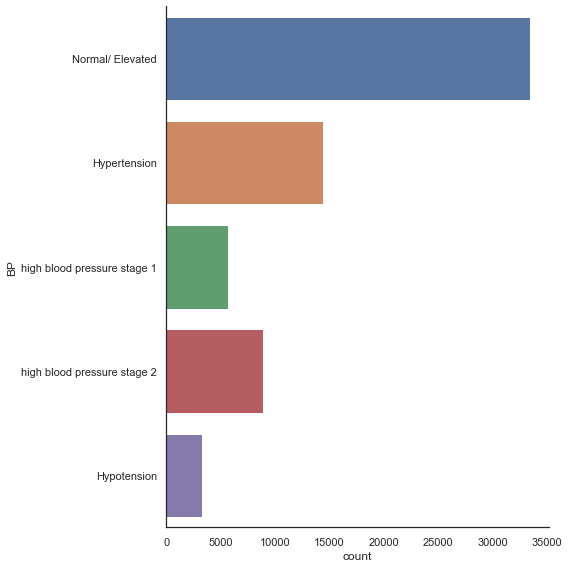

In [59]:
#Viewing ratios of BP (blood pressure classes) in terms of class using catplot and describe method
BP = pd.DataFrame(data1['BP'])
sb.catplot(y = 'BP', data = data1, kind = "count", height = 8)
BP.describe()

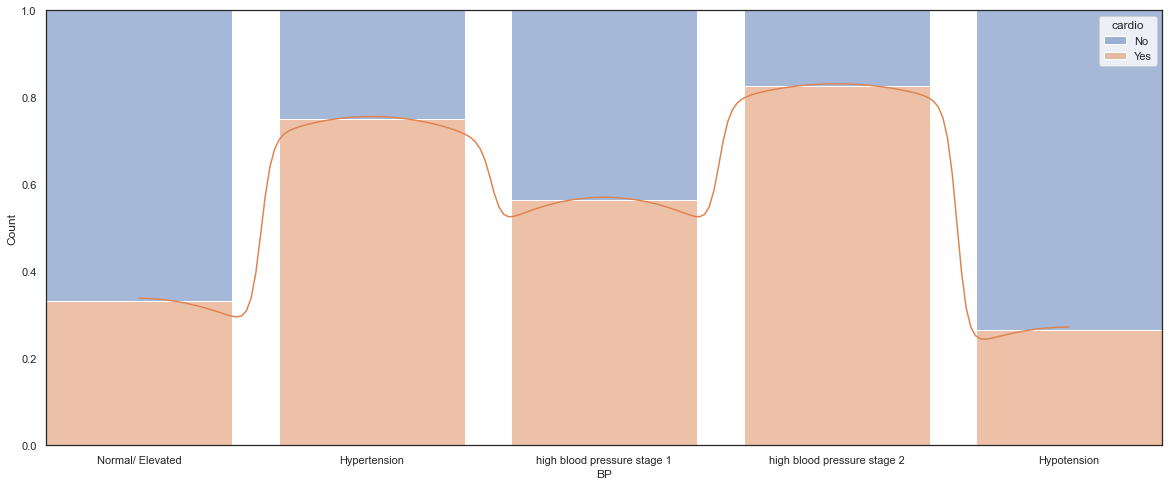

In [60]:
# viewing graph of BP wrt cvd

fig15, ax15 = plt.subplots(figsize=(20, 8))

sns.histplot(data=data1, x="BP", hue="cardio", shrink=0.8, multiple="fill", kde=True, ax=ax15)
plt.show()

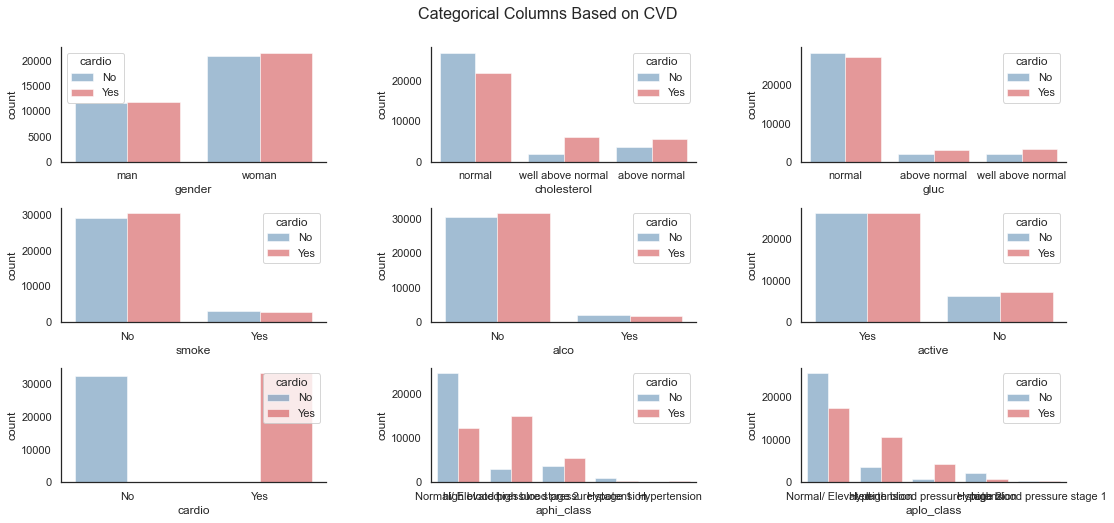

In [61]:
# Categorical Columns Based on CVD in bargraphs 
# Visual data representation
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 8))

fig.suptitle('Categorical Columns Based on CVD', y = 0.95, fontsize = 16)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

for pos, name in enumerate(categorical_cols[:-1]):
  sns.countplot(data = data1, x = name, hue = 'cardio', ax = axes.flat[pos], palette = palette, alpha = 0.5);

sns.despine()

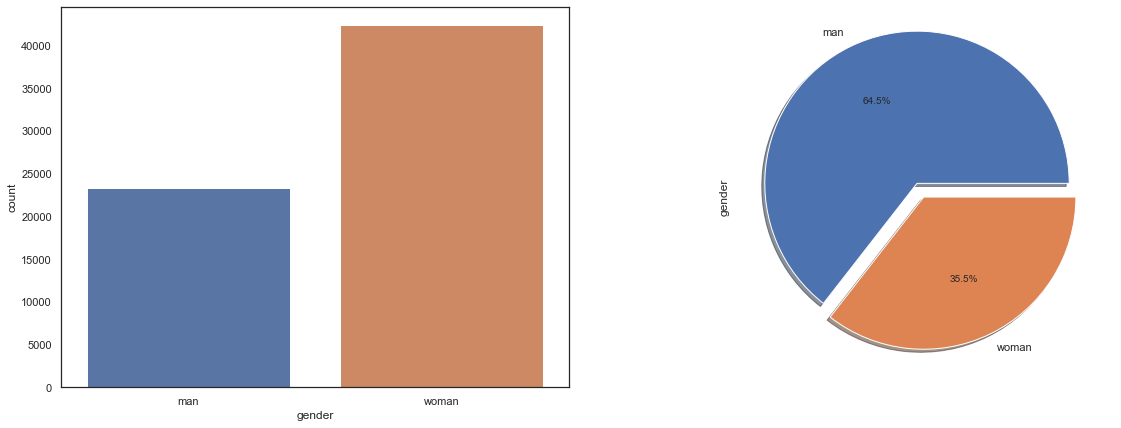

In [62]:
# visual data pie chart for gender

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.countplot(data=data1, x="gender", ax=ax[0])
data1["gender"].value_counts().plot.pie(explode=[0.1, 0], autopct="%1.1f%%", labels=["man", "woman"], shadow=True, ax=ax[1])

plt.show()

In [63]:
print("Gender Ratio (in Percentage):")
print(round(data1.gender.value_counts() / data1.gender.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence in Men and Women (in Percentage):")
print(round(data1.groupby('gender')['cardio'].value_counts() / data1.groupby('gender')['cardio'].count() * 100, 2))

Gender Ratio (in Percentage):
woman    64.46
man      35.54
Name: gender, dtype: float64
---------------------------------------

Cardiovascular Disease Presence in Men and Women (in Percentage):
gender  cardio
man     Yes       50.78
        No        49.22
woman   Yes       50.67
        No        49.33
Name: cardio, dtype: float64


#### From the gender ratio above, we can see that there are men than women in the data given, however, the presence of cvd is about ~0.5, hence gender may not play an important role determining the presence of cvd based on the analysis of this data.

In [64]:
print("Cholesterol levels (in Percentage):")
print(round(data1.cholesterol.value_counts() / data1.cholesterol.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence in Cholesterol levels (in Percentage):")
print(round(data1.groupby('cholesterol')['cardio'].value_counts() / data1.groupby('cholesterol')['cardio'].count() * 100, 2))

Cholesterol levels (in Percentage):
normal               73.90
above normal         14.17
well above normal    11.93
Name: cholesterol, dtype: float64
---------------------------------------

Cardiovascular Disease Presence in Cholesterol levels (in Percentage):
cholesterol        cardio
above normal       Yes       59.68
                   No        40.32
normal             No        55.14
                   Yes       44.86
well above normal  Yes       76.32
                   No        23.68
Name: cardio, dtype: float64


#### From cholesterol levels ratio above, we can see that there are much more datas given for people with normal cholesterol level. However if you were to look at the presence of cvd in terms of cholesterol levels, we can see that people with cholesterol level of well above normal has the highest percentage of having cvd nwith ~76%. though there are less datas for cholesterol level of well above normal, it is still safe to say that cholesterol level could play a vital role in determining the presence of cvd, and hence people with higher cholesterol levels are more likely to get cvd based on analysis of this data.

In [65]:
print("Glucose Level Ratio (in Percentage):")
print(round(data1.gluc.value_counts() / data1.gluc.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence in Glucose levels (in Percentage):")
print(round(data1.groupby('gluc')['cardio'].value_counts() / data1.groupby('gluc')['cardio'].count() * 100, 2))

Glucose Level Ratio (in Percentage):
normal               84.35
well above normal     7.92
above normal          7.73
Name: gluc, dtype: float64
---------------------------------------

Cardiovascular Disease Presence in Glucose levels (in Percentage):
gluc               cardio
above normal       Yes       58.89
                   No        41.11
normal             No        51.08
                   Yes       48.92
well above normal  Yes       61.80
                   No        38.20
Name: cardio, dtype: float64


#### From glucose levels ratio above, we can see that there are much more datas given for people with normal glucose level. However if you were to look at the presence of cvd in terms of glucose levels, we can see that people with glucose level of well above normal has the highest percentage of having cvd with ~62%. though there are less datas for glucose level of well above normal, it is still safe to say that glucose level could play a vital role in determining the presence of cvd, and hence people with higher glucose levels are more likely to get cvd based on the analysis of this data

In [66]:
print("Smokers Ratio (in Percentage):")
print(round(data1.smoke.value_counts() / data1.smoke.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence for Smokers (in Percentage):")
print(round(data1.groupby('smoke')['cardio'].value_counts() / data1.groupby('smoke')['cardio'].count() * 100, 2))

Smokers Ratio (in Percentage):
No     90.81
Yes     9.19
Name: smoke, dtype: float64
---------------------------------------

Cardiovascular Disease Presence for Smokers (in Percentage):
smoke  cardio
No     Yes       51.09
       No        48.91
Yes    No        53.04
       Yes       46.96
Name: cardio, dtype: float64


#### From smokers ratio above, ~90% of the datas presented are non-smokers. however, the presence of cvd for smokers and non-smokers are about ~0.5, hence smokers may not neccessarily play an important role determining the presence of cvd based on the analysis of this data.

In [67]:
print("People who drinks alcohol (in Percentage):")
print(round(data1.alco.value_counts() / data1.alco.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence for alcohol-drinkers (in Percentage):")
print(round(data1.groupby('alco')['cardio'].value_counts() / data1.groupby('alco')['cardio'].count() * 100, 2))

People who drinks alcohol (in Percentage):
No     94.39
Yes     5.61
Name: alco, dtype: float64
---------------------------------------

Cardiovascular Disease Presence for alcohol-drinkers (in Percentage):
alco  cardio
No    Yes       50.88
      No        49.12
Yes   No        52.18
      Yes       47.82
Name: cardio, dtype: float64


#### From the ratio of people that drinks alcohol above, ~95% of the datas presented do not drink alcohol. However, the presence of cvd for drinkers and non-drinkers are about ~0.5, Hence people who drink alcohol may not neccessarily play an important role determining the presence of cvd just based on this data.

In [68]:
print("People who has active-lifestyle (in Percentage):")
print(round(data1.active.value_counts() / data1.active.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence for active-people (in Percentage):")
print(round(data1.groupby('active')['cardio'].value_counts() / data1.groupby('active')['cardio'].count() * 100, 2))

People who has active-lifestyle (in Percentage):
Yes    79.8
No     20.2
Name: active, dtype: float64
---------------------------------------

Cardiovascular Disease Presence for active-people (in Percentage):
active  cardio
No      Yes       53.66
        No        46.34
Yes     No        50.03
        Yes       49.97
Name: cardio, dtype: float64


#### From the ratio of people who has active lifestyle above, ~80% of the datas presented are people who are active. However, the presence of cvd for people who are active and people who are not active are about ~0.5, hence people who does not exercise may not neccessarily play an important factor determining the presence of cvd based on this data.

In [170]:
print("BP levels (in Percentage):")
print(round(data1.BP.value_counts() / data1.BP.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence in BP levels (in Percentage):")
print(round(data1.groupby('BP')['cardio'].value_counts() / data1.groupby('BP')['cardio'].count() * 100, 2))

BP levels (in Percentage):
Normal/ Elevated               50.91
Hypertension                   21.94
high blood pressure stage 2    13.53
high blood pressure stage 1     8.64
Hypotension                     4.98
Name: BP, dtype: float64
---------------------------------------

Cardiovascular Disease Presence in BP levels (in Percentage):
BP                           cardio
Hypertension                 Yes       75.04
                             No        24.96
Hypotension                  No        73.39
                             Yes       26.61
Normal/ Elevated             No        66.86
                             Yes       33.14
high blood pressure stage 1  Yes       56.31
                             No        43.69
high blood pressure stage 2  Yes       82.70
                             No        17.30
Name: cardio, dtype: float64


#### It is very evident that we can see people with higher BP(>hbp stage 2) levels tend to have cvd based on the analysis of this data.

### Conclusion of EDA: Based on the EDA, we noted that the variables; age, weight/ BMI, ap_hi and ap_lo, cholesterol level, glucose level and BP level are actually physical attributes and it is heavily contributed to CVD. The variables alcohol, active and smoke can be considered as lifestyle attributes and it does not heavily contributed to CVD.

## 5. Machine Learning

### Applying machine learning techniques to see which is the most suitable model to predict CVD.

In [69]:
data = pd.read_csv('cardio_train.csv', delimiter=";")

# changing age --> days to year
data['age'] =  (data['age']/365).astype("int64")

# changing weight --> float to int
data['weight'] =  data['weight'].astype("int64")

data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62,110,80,1,1,0,0,1,0
1,1,55,1,156,85,140,90,3,1,0,0,1,1
2,2,51,1,165,64,130,70,3,1,0,0,0,1
3,3,48,2,169,82,150,100,1,1,0,0,1,1
4,4,47,1,156,56,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72,135,80,1,2,0,0,0,1


In [70]:
numeric_cols = data.select_dtypes(include = np.number).columns.tolist()
print("Numerical Columns:", numeric_cols)

Numerical Columns: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [71]:
for x in data.index:
  if data.loc[x, "ap_hi"] > 300:
    data.drop(x, inplace = True)
    
for x in data.index:
  if data.loc[x, "ap_hi"] <= 0:
    data.drop(x, inplace = True)


# dropping Diastolic blood pressure that are more than 300 & less than or equal to 0 
for x in data.index:
  if data.loc[x, "ap_lo"] > 300:
    data.drop(x, inplace = True)
    
for x in data.index:
  if data.loc[x, "ap_lo"] <= 0:
    data.drop(x, inplace = True)

data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62,110,80,1,1,0,0,1,0
1,1,55,1,156,85,140,90,3,1,0,0,1,1
2,2,51,1,165,64,130,70,3,1,0,0,0,1
3,3,48,2,169,82,150,100,1,1,0,0,1,1
4,4,47,1,156,56,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72,135,80,1,2,0,0,0,1


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import ensemble
import xgboost as xgb
from sklearn.metrics import  accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score,classification_report ,plot_confusion_matrix

In [75]:
x = data[[ 'ap_hi', 'age', 'ap_lo', 'cholesterol', 'weight', 'height','gender', 'smoke', 'alco', 'active', 'gluc']]
y = data['cardio']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)


### XGBoost model

In [76]:
#XGBoost model

xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train,y_train)

#fitting the classifier on the training data

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [77]:
pre7=xgb_model.predict(x_test)
xgb_score=accuracy_score(y_test,pre7)
print(xgb_score)

0.7346524606798579


<Figure size 3600x3600 with 0 Axes>

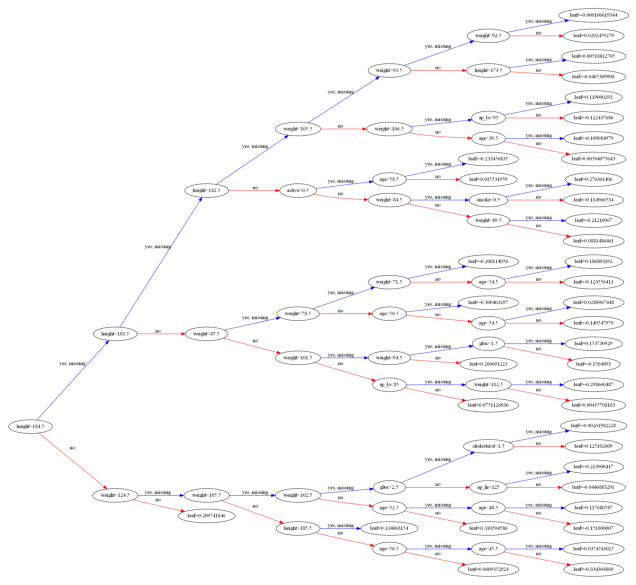

In [78]:
from xgboost import plot_tree
plt.figure(figsize=(50,50))
plot_tree(xgb_model,rankdir='LR',num_trees=-1)
plt.gcf().set_size_inches(18.5, 10.5)

plt.show()
#Tree visualization for xgboost. This is similar to Decision Tree or Random Forest. How ever, their pattern of building the trees is very different. 

In [191]:
# tuning the XGBoost
xgb_tune= xgb.XGBClassifier()

In [192]:
params = { 'max_depth': np.arange(2, 30, 1),
           'learning_rate': np.arange(0.01, 0.1, 0.01),
           'colsample_bytree': np.arange(0.1, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.1, 1.0, 0.1),
          'subsample': np.arange(0.1, 1.0, 0.1),
          'reg_lambda' : np.arange(0,2.0,0.1),
          'reg_alpha': np.arange(0,2.0,0.1),
         'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
          'n_estimators': np.arange(10, 1000, 10),
          'min_child_weight' :np.arange(0, 100, 5)}

# reg_lambda and reg_alpha are regularization terms on weights. Increasing these values will make model more conservative.
# colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
# colsample_bylevel is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree.
# subsample is the Subsample ratio of the training instances.
# min_child_weight is Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results
# in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning
# n_estimators is the number of trees used.
# max_depth is Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 

In [193]:
clf = RandomizedSearchCV(estimator=xgb_tune,
                         param_distributions=params,
                      scoring='roc_auc',
                         n_iter=25,
                         verbose=3,cv=5,n_jobs=-1
                        
                        )
# This cell creates an instance for the tuning along with number of iterations (n_iter), verbose (Verbosity of printing messages), cv (cross validation), 
# n_jobs (the maximum number of concurrently running worker).

In [194]:
clf.fit(x_train,y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7...
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910,
       920, 930, 940, 950, 960, 970, 980, 990]),
                                        'reg_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'reg_lambda': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,

In [195]:
clf.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.5,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.3,
 'learning_rate': 0.04,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 450,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 1.7000000000000002,
 'reg_lambda': 1.1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.6,
 'verbosity': 1}

In [196]:
improved_xgb = xgb.XGBClassifier(base_score= 0.5,
 booster='gbtree',
 colsample_bylevel= 0.8,
 colsample_bynode= 1,
 colsample_bytree=0.8,
 gamma= 0.3,
 learning_rate= 0.01,
 max_delta_step= 0,
 max_depth=27,
 min_child_weight= 50,
 missing= None,
 n_estimators= 520,
 n_jobs= 1,
 nthread= None,
 objective='binary:logistic',
 random_state= 0,
 reg_alpha=  1.6,
 reg_lambda= 0.1,
 scale_pos_weight= 1,
 seed= None,
 silent= None,
 subsample= 0.4,
 verbosity= 1) 

In [197]:
improved_xgb.fit(x_train, y_train)
pre4=improved_xgb.predict(x_test)
improved_xgb_score=accuracy_score(y_test,pre4)

In [198]:
improved_xgb_score

0.7385663550047111

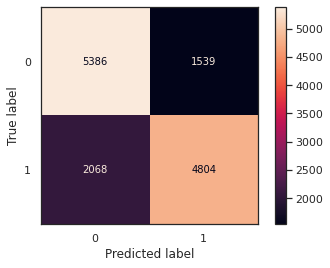

In [199]:
plot_confusion_matrix(improved_xgb,x_test,y_test, cmap = None )
plt.grid(False)

### Random Forest model

#### Random forest utilizes the bagging concept which is also known as bootstrap aggregation, whereby we create multiple different random trees 

#### Pros: Since they are created from subsets of data and the final output is based on average or majority ranking, the problem of overfitting doesn’t happen here. 
#### Random Forest randomly selects observations through bootstrapping, builds a decision tree and then the result is obtained based on majority voting amongst all the decision trees generated. No formulas are required here.
#### CONS 
#### It is slower as many trees are generated and processed before majority voting is aggregated.

In [200]:
rc=RandomForestClassifier(n_estimators = 1000)
rc.fit(x_train,y_train)
rc_score = rc.score(x_test, y_test)

# n_estimators refers to the number of parallel trees generated before combining the yield of
# each tree predictions together based on Majority Voting
# this step is known as bagging and done using an Ensemble Classifier


# fit our train data set into the machine learning model
# and test the model with our test set data and test its accuracy.

### Random Forest Optimization using Hyperparameter tuning.

In [201]:
Classifier = ensemble.RandomForestClassifier(n_jobs =-1)
params = {'n_estimators':np.arange(100, 1500, 100),
          'max_depth': np.arange(1,20),
          'criterion': ['gini', 'entropy']

          }

# n_jobs: Conveys to the engine how many processors are allowed to use. 
# If the value is 1, it can use only one processor, but if the value is -1,, there is no limit.
# max_depth refers to the range to let the model know how many layers are there in a decision tree
# Ensemble methods are techniques that create multiple models and then combine them to produce improved results. 
# Ensemble methods usually produces more accurate solutions than a single model would.

In [202]:
from sklearn import model_selection
model = model_selection.RandomizedSearchCV( estimator = Classifier,
                                     param_distributions = params,
                                     n_iter = 10,
                                     scoring = 'accuracy',
                                     verbose = 10,
                                     cv = 5,
                                     n_jobs =1)

#classifier - 

In [203]:
# This fits the train data through the optimizer function and the output score will be produced by generating trees while varying the parameters.
model.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=1100..........
[CV 1/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=1100;, score=0.719 total time=  11.7s
[CV 2/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=1100..........
[CV 2/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=1100;, score=0.730 total time=  11.7s
[CV 3/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=1100..........
[CV 3/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=1100;, score=0.719 total time=  11.6s
[CV 4/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=1100..........
[CV 4/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=1100;, score=0.729 total time=  11.4s
[CV 5/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=1100..........
[CV 5/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=1100;, score=0.730 total time=  11.6s
[CV 1/5; 2/10] START cri

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400])},
                   scoring='accuracy', verbose=10)

In [204]:
# this outputs the best score obtained through varying the parameters 
# we can also retrieve the parameter version that produces the best score value
print(model.best_score_)
print(model.best_estimator_.get_params())

0.7317352791315209
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [81]:
# now that we know which parameters are the best parameters to configure to, 
# we will redo the randomforest function with its optimized parameters
rc_improved = RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0, class_weight= None, criterion= 'entropy', 
max_depth=12, max_features='auto', max_leaf_nodes= None, max_samples= None,
 min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2,
  min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs= -1, 
oob_score= False, random_state= None, verbose= 0, warm_start= False)


In [82]:
# using the function with the optimized parameters, we will generate an improved score.
rc_improved.fit(x_train, y_train)
pre3 = rc_improved.predict(x_test)
rc_improved_score = rc_improved.score(x_test, y_test)

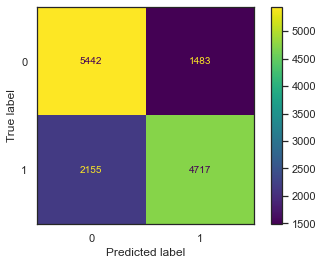

In [83]:
# This shows the confusion matrix of the function to visualise its accuracy in a visual representation.
plot_confusion_matrix(rc_improved,x_test,y_test)
plt.grid(False)

[Text(0.5836530780075188, 0.9615384615384616, 'ap_lo <= 84.5\nentropy = 1.0\nsamples = 34882\nvalue = [27952, 27236]\nclass = y[0]'),
 Text(0.3677854793233083, 0.8846153846153846, 'ap_hi <= 128.5\nentropy = 0.959\nsamples = 24811\nvalue = [24287, 14936]\nclass = y[0]'),
 Text(0.2103218984962406, 0.8076923076923077, 'ap_lo <= 78.5\nentropy = 0.896\nsamples = 20015\nvalue = [21780, 9887]\nclass = y[0]'),
 Text(0.10648966165413534, 0.7307692307692307, 'height <= 61.5\nentropy = 0.8\nsamples = 6298\nvalue = [7516, 2409]\nclass = y[0]'),
 Text(0.046701127819548875, 0.6538461538461539, 'age <= 52.5\nentropy = 0.655\nsamples = 1897\nvalue = [2468, 501]\nclass = y[0]'),
 Text(0.018609022556390978, 0.5769230769230769, 'age <= 44.5\nentropy = 0.492\nsamples = 1211\nvalue = [1706, 205]\nclass = y[0]'),
 Text(0.005714285714285714, 0.5, 'ap_lo <= 59.5\nentropy = 0.361\nsamples = 572\nvalue = [840, 62]\nclass = y[0]'),
 Text(0.005112781954887218, 0.4230769230769231, 'entropy = 0.0\nsamples = 12\nval

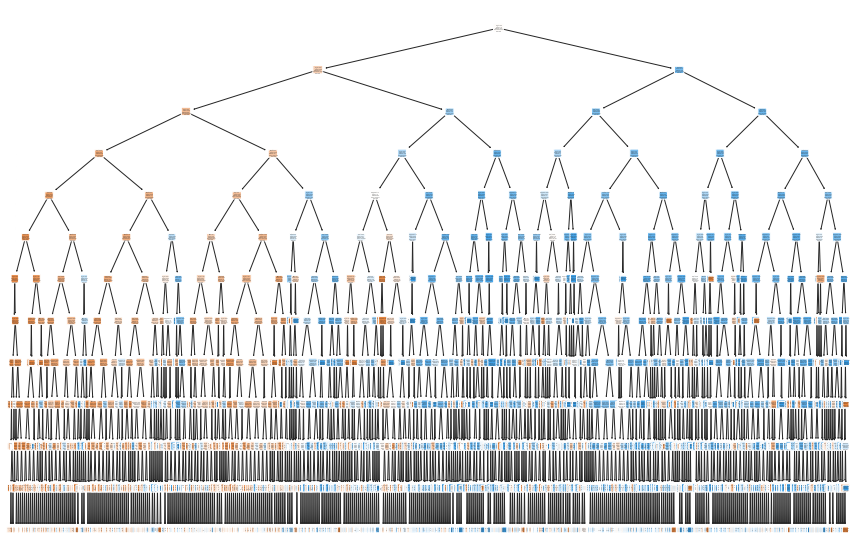

In [84]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# one specific tree of index "5" with a max depth of 12
fig = plt.figure(figsize=(15, 10))
plot_tree(rc_improved.estimators_[5], 
          feature_names=['ap_hi', 'age', 'ap_lo', 'weight', 'height','aplo_class','aphi_class','BP',"cholesterol","alco","active","smoke","gluc"],
          class_names=True, 
          filled=True, impurity=True, 
          rounded=True)

### Logistic Regression model

In [213]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(x_train, y_train)

log_reg_score = log_reg.score(x_test, y_test)

In [214]:
log_para_grid = [{
   
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter' : np.arange(100, 2000, 100)
    
}]

In [215]:
clf_logreg = GridSearchCV(log_reg, param_grid = log_para_grid, cv = 3, verbose = True)

In [216]:
best_param = clf_logreg.fit(x_train, y_train)

Fitting 3 folds for each of 95 candidates, totalling 285 fits


In [217]:
best_param.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [218]:
improved_log_reg = LogisticRegression(C= 29.763514416313132,
 class_weight= None,
 dual= False,
 fit_intercept= True,
 intercept_scaling= 1,
 l1_ratio= None,
 max_iter= 5000,
 multi_class= 'auto',
 n_jobs= None,
 penalty= 'l2',
 random_state= None,
 solver= 'lbfgs',
 tol= 0.0001,
 verbose= 0,
 warm_start= False)

In [219]:
improved_log_reg.fit(x_train, y_train)

LogisticRegression(C=29.763514416313132, max_iter=5000)

In [220]:
improved_log_reg.score(x_test, y_test)
pre1 = log_reg.predict(x_test)

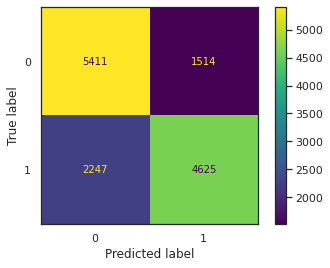

In [221]:
plot_confusion_matrix(improved_log_reg,x_test,y_test)
plt.grid(False)

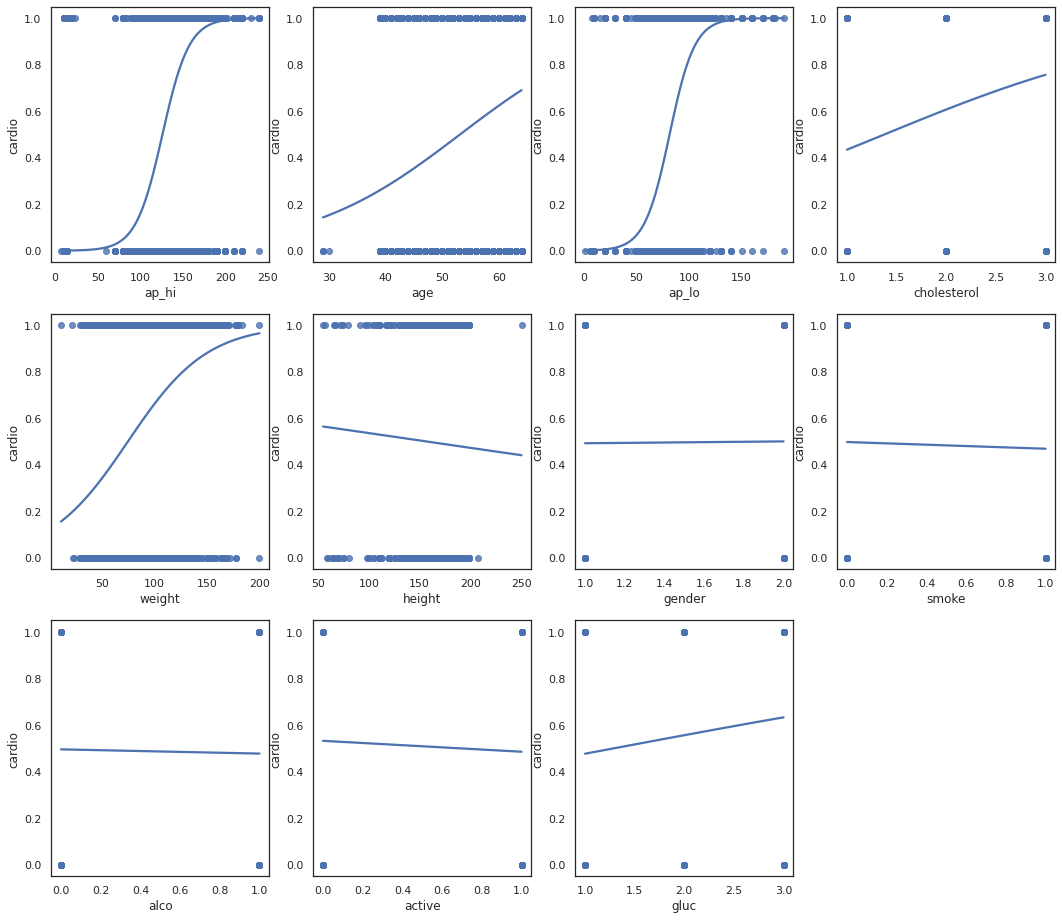

In [222]:
f, axes = plt.subplots(12, 1, figsize=(18, 16))

plt.subplot(3,4,1)
sb.regplot(x=x['ap_hi'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,2)
sb.regplot(x=x['age'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,3)
sb.regplot(x=x['ap_lo'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,4)
sb.regplot(x=x['cholesterol'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,5)
sb.regplot(x=x['weight'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,6)
sb.regplot(x=x['height'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,7)
sb.regplot(x=x['gender'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,8)
sb.regplot(x=x['smoke'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,9)
sb.regplot(x=x['alco'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,10)
sb.regplot(x=x['active'], y=y, data=data, logistic=True, ci=None)
plt.subplot(3,4,11)
sb.regplot(x=x['gluc'], y=y, data=data, logistic=True, ci=None)

plt.show()


#### The above graphs show the logistic regression fit for the trainijng data. The y axis represents the probability (of heart disease) that is calcuated uing the sigmoid function and the x axis of each plot is a train data column. Based on the probability being colser to 0 or 1, it is rounded of as 0 or 1.

### Decision Tree model

In [223]:
dc=DecisionTreeClassifier(max_depth= 3)

In [224]:
dc.fit(x_train, y_train)
dectree_score = dc.score(x_test, y_test)

#### Hyperparameter Tuning using Decision Tree model.

In [225]:
dcpara_grid = { 
                'criterion': ['gini', 'entropy'],
               'max_depth': [1,2,3,4,5,6,7, None],
            
    
}

# criterion and max_depth are the only two parameters that show change in accuracy when varied. Therefore, we only tune these.
 

In [226]:
dectree_param_finder = GridSearchCV(dc, param_grid = dcpara_grid, cv =10, n_jobs = -1)
dectree_param_finder.fit(x_train, y_train )

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, None]})

In [227]:
dectree_param_finder.best_estimator_.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [228]:
improved_dectree = DecisionTreeClassifier(ccp_alpha= 0.0,
 class_weight= None,
 criterion= 'entropy',
 max_depth= 7,
 max_features=None,
 max_leaf_nodes=None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split=2,
 min_weight_fraction_leaf= 0.0,
 random_state= None,
 splitter= 'best')

In [229]:
improved_dectree.fit(x_train, y_train)
pre2 = improved_dectree.predict(x_test)
improved_dectree_score = improved_dectree.score(x_test, y_test)

In [230]:
improved_dectree_score

0.7316808001739509

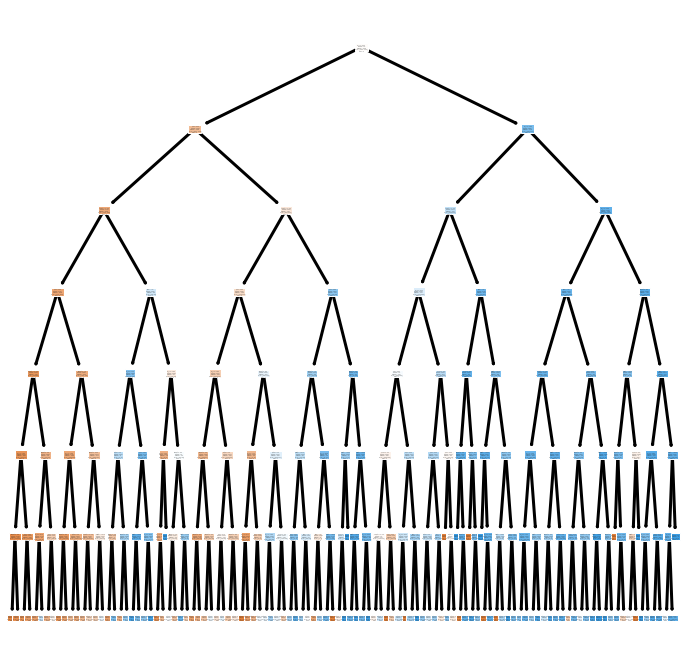

In [231]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(improved_dectree, 
          feature_names = x_train.columns,
          class_names = [str(x) for x in improved_dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

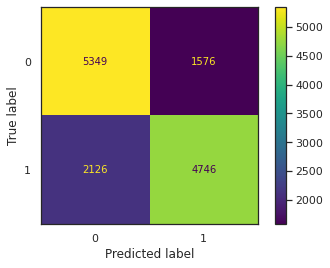

In [232]:
plot_confusion_matrix(improved_dectree,x_test,y_test)
plt.grid(False)

### Feature Importance:
#### The feature importance is a metric that simply shows the how crucial and contributing each feature is the for the algorithm. It varies from algorithm to algorithm.

In [233]:
column_names = list(x.columns)

column_names

['ap_hi',
 'age',
 'ap_lo',
 'cholesterol',
 'weight',
 'height',
 'gender',
 'smoke',
 'alco',
 'active',
 'gluc']

Text(0.5, 1.0, 'Feature Importance : XGBOOST')

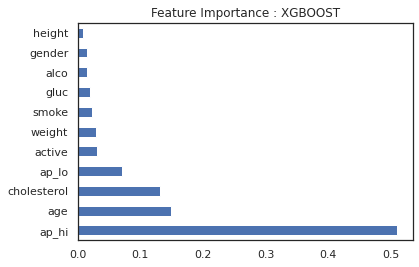

In [234]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Feature Importance : XGBOOST')

Text(0.5, 1.0, 'Feature Importance : Random Forest ')

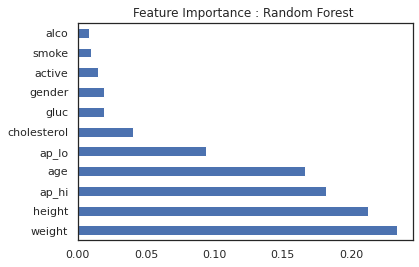

In [235]:
feat_importances = pd.Series(rc.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Feature Importance : Random Forest ')

Text(0.5, 1.0, 'Feature Importance : Decision Tree ')

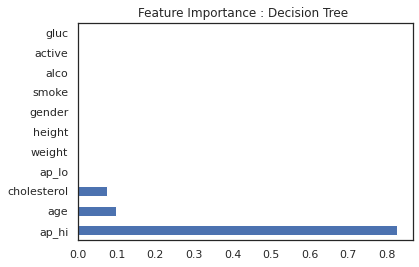

In [236]:
feat_importances = pd.Series(dc.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Feature Importance : Decision Tree ')

## 6. Machine Learning Summary

In [237]:
model_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest',  'XGBoost Classifier'],
    'Initial Accuracy': [log_reg_score, dectree_score, rc_score, xgb_score  ],
    'Improved Accuracy': [log_reg_score, improved_dectree_score, rc_improved_score, improved_xgb_score ],
    'F1 Score': [f1_score(y_test,pre1), f1_score(y_test,pre2), f1_score(y_test,pre3), f1_score(y_test,pre4)]
    

})

In [240]:
model_summary

,Model,Initial Accuracy,Improved Accuracy,F1 Score
0,Logistic Regression,0.728709,0.728709,0.712232
1,Decision Tree,0.726172,0.731681,0.719418
2,Random Forest,0.713126,0.735885,0.721151
3,XGBoost Classifier,0.736175,0.738566,0.727053


### Conclusion

* Based on the obtained results, XGBoost Classifier is the most accurate model for this binary classification prediction. It is probably due to a better combination of prediction performance and processing time compared to other algorithms.

* The accuracy is not very high for this dataset probably due to lot of columns simply being binary. A more continous data can generate a more accurate prediction. For example, the alcohol column is a binary value but in actuality, the level and rate of consumption effect the outcome of the disease.

* The F1 score is a commonly used metric that shows the harmonic average of the precision and recall metrics.




### Hyperparameter Tuning

#### This is an optmization method that we have used on all our Machine Learning Models, except for Logistic Regression. This technique involves feeding a search method with a list of hyperparameter values that vary from model to model. The method then fits the values to generate the most accurate prediction parameters that are used to recreate the model. This could not be performed on Logistic Regression since it needed lot more fits and is supported by common processor speed. It can therefore be done on a Supercomputer.



REFERENCES

https://www.nvidia.com/en-us/glossary/data-science/xgboost/#:~:text=XGBoost%2C%20which%20stands%20for%20Extreme,%2C%20classification%2C%20and%20ranking%20problems.

https://www.jeremyjordan.me/hyperparameter-tuning/

https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

## 7. Extras/ Extension - Calculating if a person has CVD with User Input (User-friendly)


In [100]:
#data2 is for extras/ extension
#remove 'id' since unneccessary.
data2 = pd.read_csv('cardio_train.csv', delimiter=";").drop('id', axis=1)

# changing age --> days to year
data2['age'] =  (data2['age']/365).astype("int64")

# changing weight --> float to int
data2['weight'] =  data2['weight'].astype("int64")

# combine height and weight to bmi
data2['BMI'] = (data2['weight']/(data1['height']/100)**2).round()


#drop duplicates
data2.duplicated().sum()

data2.drop_duplicates(inplace = True)

# dropping Systolic blood pressure that are more than 300 & less than or equal to 0
for x in data2.index:
  if data2.loc[x, "ap_hi"] > 300:
    data2.drop(x, inplace = True)
    
for x in data2.index:
  if data2.loc[x, "ap_hi"] <= 0:
    data2.drop(x, inplace = True)


# dropping Diastolic blood pressure that are more than 300 & less than or equal to 0 
for x in data2.index:
  if data2.loc[x, "ap_lo"] > 300:
    data2.drop(x, inplace = True)
    
for x in data1.index:
  if data2.loc[x, "ap_lo"] <= 0:
    data2.drop(x, inplace = True)
    
def aphi_func(y):
    
    if y >= 0 and y<= 90:
         return 5 #hypotension
    if y >90 and y<= 129:
         return 1 #normal/ elevated
        
    if y >129 and y<= 139:
         return 2 #hbp stage 1
    if y >139 and y<= 180:
         return 3 #hbp stage 2
    else:
         return 4 #hbp hypertensive 
        
def aplo_func(y):
    
    if y >= 0 and y<= 60:
        return 5 #hypotension
    if y >60 and y <= 80:
         return 1 #normal/ elevated
        
    if y > 80  and y <= 89:
         return 2 #hbp stage 1
        
    if y >90 and y<= 120:
         return 3 #hbp stage 2
    
    else:
         return 4 #hbp hypertensive
        
data2['aphi_class'] = data2['ap_hi'].apply(lambda y: aphi_func(y))
data2['aplo_class'] = data2['ap_lo'].apply(lambda y: aplo_func(y))

data2['BP']=data2[['aphi_class','aplo_class']].max(axis=1)

data2.head(5) #show first 5

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,aphi_class,aplo_class,BP
0,50,2,168,62,110,80,1,1,0,0,1,0,22.0,1,1,1
1,55,1,156,85,140,90,3,1,0,0,1,1,35.0,3,4,4
2,51,1,165,64,130,70,3,1,0,0,0,1,24.0,2,1,2
3,48,2,169,82,150,100,1,1,0,0,1,1,29.0,3,3,3
4,47,1,156,56,100,60,1,1,0,0,0,0,23.0,1,5,5


In [104]:
## extension check if a person has cvd w/ user input

age = float(input('Age: ' ))
age = int(age)
ht = float(input('Height: ' ))
ht = int(ht)
wt = float(input('Weight: '))
wt = int(wt)
active = int(input('Are you an active person?(1=Yes, 0=No): '))
smoke = int(input('Do you smoke?(1=Yes, 0=No): '))
cholestrol = int(input('Cholesterol level?(1=Normal, 2=Above Normal, 3=Well Above Normal): '))
gluc = int(input('Glucose level?(1=Normal, 2=Above Normal, 3=Well Above Normal): '))
alco = int(input('Alcohol level?: 1=Drink, 0=Does Not Drink: '))
BP = int(input('BP level?(1=Normal/ Elevated, 2=Stage 2, 3=Stage 3, 4= Hypertension, 5= Hypotension): '))
BMI = round(wt/((ht/100)*(ht/100)),1)
#bmi = round(bmi,2)

Age: 24
Height: 180
Weight: 120
Are you an active person?(1=Yes, 0=No): 0
Do you smoke?(1=Yes, 0=No): 1
Cholesterol level?(1=Normal, 2=Above Normal, 3=Well Above Normal): 3
Glucose level?(1=Normal, 2=Above Normal, 3=Well Above Normal): 3
Alcohol level?: 1=Drink, 0=Does Not Drink: 1
BP level?(1=Normal/ Elevated, 2=Stage 2, 3=Stage 3, 4= Hypertension, 5= Hypotension): 4


In [105]:
LMN=(age,BMI,BP,cholestrol,gluc,smoke,alco,active)
LMN

(24, 37.0, 4, 3, 3, 1, 1, 0)

In [106]:
# Using XGBoost model since it has the highest accuracy.

fn_pred_x= pd.DataFrame(data2[['age','BMI','BP','cholesterol','gluc','smoke','alco','active']])
fn_pred_y= pd.DataFrame(data2[['cardio']])

fn_pred_x.head()
fn_pred_y.head()

pred_test = xgb.XGBClassifier()
pred_test.fit(fn_pred_x,fn_pred_y)
#data_prediction=np.array([55,35,107,3,1,0,0,1]).reshape(1,-1)
#data_prediction=np.array(data_s).reshape(1,-1)
sed=np.array(LMN).reshape(1,-1)
pred_test.predict(sed)

#print (pred_test.predict(sed))
abcd=int(pred_test.predict(sed))
print('BMI: ',BMI)
if abcd == 0:
    print('You might have low risk of CVD.')
else:
    print('You might have high risk of CVD.')

BMI:  37.0
You might have high risk of CVD.
